In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path

In [2]:
import mxnet as mx

In [3]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [4]:
calendar = pd.read_csv('calendar.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [5]:
from mxnet import gluon
import seaborn as sns

In [6]:
date_col = [col for col in sales_train_validation if col.startswith('d_')]

In [7]:
sales_train_validation['total_sales'] = sales_train_validation[date_col].sum(axis=1)

# Task A - EDA

### Which state has the highest sales? (5 points)

In [8]:
#Which state has the highest sales? (5 points)
sales_train_validation['total_sales'] = sales_train_validation[date_col].sum(axis=1)
#Adding all the sales for each state
sales_train_validation.groupby('state_id').agg({"total_sales":"sum"}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


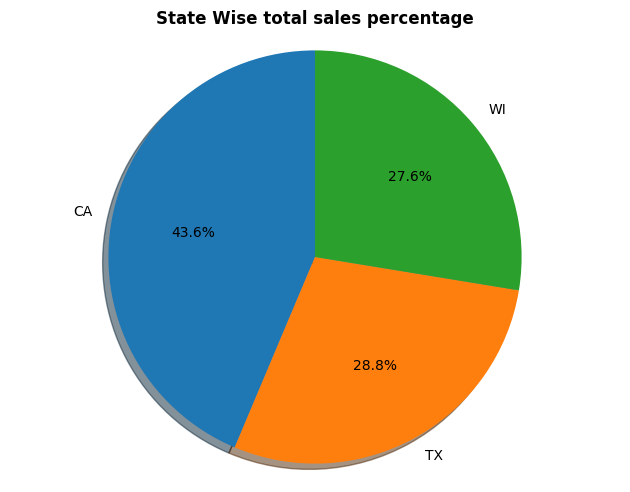

In [9]:
#Calculating the sales ratio
state_wise_sales_data = sales_train_validation.groupby('state_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
state_wise_sales_data = state_wise_sales_data.reset_index()
#Plotting the sales ratio
fig1, ax1 = plt.subplots()
ax1.pie(state_wise_sales_data['total_sales'],labels= state_wise_sales_data['state_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("State Wise total sales percentage",fontweight = "bold")
plt.show()

**CA has the highest sales**

### Which department has the highest sales? (5 points)

In [10]:
#Which department has the highest sales? (5 points)
print("Total Sales from each category")
sales_train_validation.groupby('dept_id').agg({"total_sales":"sum"}).reset_index()

Total Sales from each category


,dept_id,total_sales
0,FOODS_1,5088041
1,FOODS_2,7629822
2,FOODS_3,32372076
3,HOBBIES_1,5596460
4,HOBBIES_2,528340
5,HOUSEHOLD_1,11500526
6,HOUSEHOLD_2,2980144


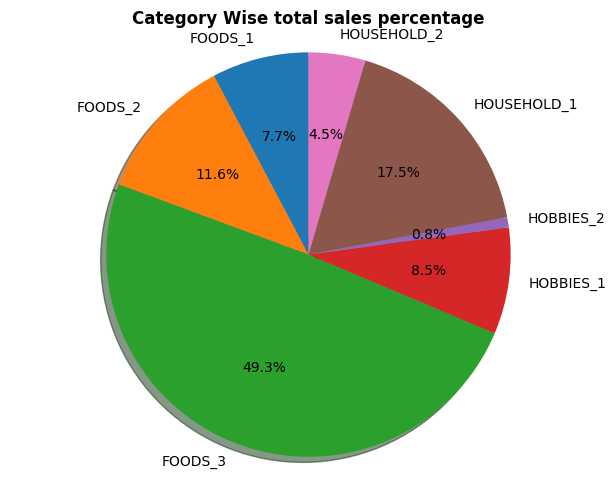

In [12]:
#Caculating the sales ratio for the 3 categories
cat_wise_sales_data = sales_train_validation.groupby('dept_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
cat_wise_sales_data = cat_wise_sales_data.reset_index()
#Plotting the sales ratio for the 3 categories
fig1, ax1 = plt.subplots()
ax1.pie(cat_wise_sales_data['total_sales'],labels= cat_wise_sales_data['dept_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Category Wise total sales percentage",fontweight = "bold")
plt.show()

**Foods_3 has the highest sales**

### Which department has the highest number of products? (5 points)


In [314]:
dept_items = sales_train_validation.groupby('dept_id')["item_id"].nunique()

In [321]:
dept_items

dept_id
FOODS_1        216
FOODS_2        398
FOODS_3        823
HOBBIES_1      416
HOBBIES_2      149
HOUSEHOLD_1    532
HOUSEHOLD_2    515
Name: item_id, dtype: int64

**Foods_3 has the highest number of products**

### Which department has the highest mean price? (5 points)

In [15]:
calendar["d"] = ["d_" + str(i) for i in range(1, 1970)]

In [16]:
import plotly.graph_objects as go
dept_list = sales_train_validation['dept_id'].unique()
means = []

In [17]:
#Which department has the highest number of products? (5 points)
past_sales = sales_train_validation.set_index('item_id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [29]:
# Which department has the highest number of products? (5 points)
cat_list = sales_train_validation['cat_id'].unique()

In [30]:
dept_product_count = sales_train_validation['cat_id'].value_counts()

In [317]:
item_mean_price = pd.DataFrame(sell_prices.groupby("item_id")["sell_price"].mean())

In [319]:
item_mean_price["dept_id"]= None
for ind in item_mean_price.index:
    for dept in sales_train_validation["dept_id"].unique():
        if ind[:-4] == dept:
            item_mean_price["dept_id"].loc[ind] = dept

In [320]:
item_mean_price.groupby("dept_id").mean()

,sell_price
dept_id,
FOODS_1,3.330305
FOODS_2,4.150541
FOODS_3,2.866296
HOBBIES_1,6.614666
HOBBIES_2,2.599003
HOUSEHOLD_1,5.170858
HOUSEHOLD_2,5.727590


**HOBBIES_1 has the highest mean price**

### Which is the best performing store? (5 points)

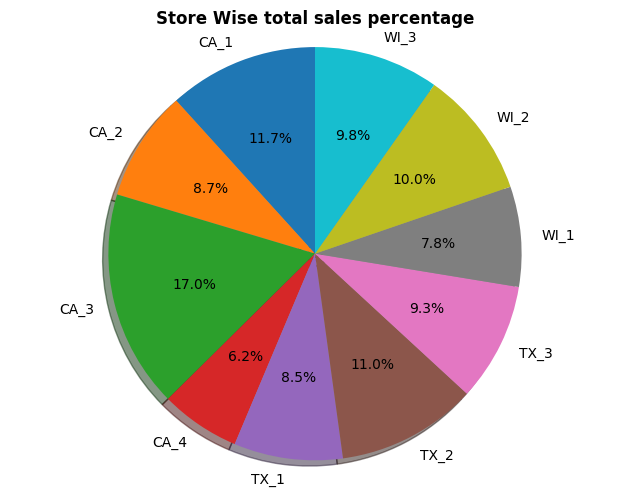

In [46]:
#Caculating the sales ratio for the 10 stores
store_wise_sales_data=sales_train_validation.groupby('store_id').agg({"total_sales":"sum"})/sales_train_validation.total_sales.sum() * 100
#Plotting the sales ratio for the 10 stores
store_wise_sales_data = store_wise_sales_data.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(store_wise_sales_data['total_sales'],labels= store_wise_sales_data['store_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Store Wise total sales percentage",fontweight = "bold")
plt.show()

**The brst performing store is CA_3**

### Which month had the highest sales? 

In [49]:
import datetime
base = datetime.datetime(2011,1,29)

In [313]:
state_level = sales_train_validation.groupby("state_id")[date_col].sum().reset_index().set_index('state_id').T
state_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
state_level.set_index('datum', drop=True, inplace=True)
state_level.sort_index(inplace=True)
state_level.head()
state_month_level = state_level.groupby(pd.Grouper(freq='1M')).sum()

In [298]:
monthly_total_sales = state_month_level.mean()

# Find the month with the highest sales
highest_sales_month = monthly_total_sales.idxmax()

# Get the highest sales value
highest_sales_value = monthly_total_sales.loc[highest_sales_month]

# Find the specific dates within the month with the highest sales
highest_sales_dates = state_month_level[highest_sales_month].idxmax()

# Print the result
print(f"The month with the highest sales is {highest_sales_month} ({highest_sales_dates}) with a total sales value of {highest_sales_value}.")

The month with the highest sales is CA (2015-08-31 00:00:00) with a total sales value of 448055.421875.


In [299]:
# Assuming `state_month_level` is the DataFrame containing the sales data
# Calculate the average sales for each weekday across states
month_avg_sales = state_month_level.groupby(state_month_level.index.month).mean()

# Find the top 3 weekdays with the highest average sales in each state
top_months = {}
for state in state_month_level.columns:
    top_months[state] = month_avg_sales[state].nlargest(3)

# Print the result
for state, months in top_months.items():
    print(f"State: {state}")
    print(months)
    print()

State: CA
datum
8     494721.8
7     481989.0
10    474876.0
Name: CA, dtype: float64

State: TX
datum
8     326257.4
7     316609.6
10    307898.6
Name: TX, dtype: float64

State: WI
datum
3     299488.333333
12    293929.000000
8     293366.800000
Name: WI, dtype: float64



**August had the highest sales**

### Which weekday do people prefer to grocery shopping in different states? (3 answers = 15 points)

In [74]:
state_week_level = state_level.groupby(pd.Grouper(freq='1D')).sum()
state_week_level.head()

state_id,CA,TX,WI
datum,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309


In [99]:
# Assuming `state_month_level` is the DataFrame containing the sales data
# Calculate the average sales for each weekday across states
state_day_level = state_level.groupby(pd.Grouper(freq='1D')).sum()
weekday_avg_sales = state_day_level.groupby(state_day_level.index.weekday).mean()

# Find the top 3 weekdays with the highest average sales in each state
top_weekdays = {}
for state in state_month_level.columns:
    top_weekdays[state] = weekday_avg_sales[state].nlargest(3)

# Print the result
for state, weekdays in top_weekdays.items():
    print(f"State: {state}")
    print(weekdays)
    print()

State: CA
datum
6    18438.003650
5    18164.434307
4    14674.586081
Name: CA, dtype: float64

State: TX
datum
6    12067.080292
5    11635.343066
0     9649.227106
Name: TX, dtype: float64

State: WI
datum
5    11747.116788
6    10624.937956
4     9928.564103
Name: WI, dtype: float64



**CA and TX people prefer to grocery shopping on SUNDAY and WI people prefer to shopping on SATURDAY**

### Which holiday or event recorded the highest sales? (5 points)

In [108]:
# Event names for each event type
events1 = calendar[['event_type_1','event_name_1',]]
events2 = calendar[['event_type_2','event_name_2',]]
events2.columns = ["event_type_1","event_name_1"]
events = pd.concat([events1,events2],ignore_index = True)
events = events.dropna().drop_duplicates()
events
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")}
print("Event Names across different Event Types")
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()]))

Event Names across different Event Types


,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,NaN
4,Father's day,ColumbusDay,Pesach End,NaN
5,Halloween,VeteransDay,Ramadan starts,NaN
6,Easter,Thanksgiving,Eid al-Fitr,NaN
7,NaN,Christmas,EidAlAdha,NaN
8,NaN,NewYear,Chanukah End,NaN
9,NaN,MartinLutherKingDay,OrthodoxChristmas,NaN


In [166]:
specific_rows = calendar[~calendar['event_name_1'].isna()]

In [183]:
event_data = calendar[~calendar['event_name_1'].isna()]

In [191]:
event_data['d']

8          d_9
16        d_17
23        d_24
39        d_40
46        d_47
         ...  
1926    d_1927
1948    d_1949
1951    d_1952
1956    d_1957
1968    d_1969
Name: d, Length: 162, dtype: object

In [272]:
# Assuming `sales_data` is the DataFrame containing the sales data for each event or holiday
# Calculate the total sales for each event
ww = sales_train_validation.iloc[:, 5:-1].sum()
ws = event_data['d']
ws = ws.iloc[:-8]
# Print the result
ww = ww.loc[ws]

# Find the event with the highest sales
highest_sales_event = ww.idxmax()

In [297]:
# Get the highest sales value
highest_sales_value = event_total_sales.loc[highest_sales_event]
event_name = calendar[calendar['d'] == highest_sales_event]['event_name_1']

# Print the result
print(f"The event with the highest sales is {event_name.values[0]} with a total sales value of {highest_sales_value}.")

The event with the highest sales is ValentinesDay with a total sales value of 48337.


**ValentinesDay recorded the highest sales**

# Task B - Deep Learning Forecasting  (50 points)

In [9]:
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2'], 
    axis=1
)

In [10]:
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

In [11]:
test_cal_features = cal_features.values.T

In [90]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
submission=True

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

In [91]:
if submission:
    train_cal_features = test_cal_features[:,:-submission_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-submission_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-submission_prediction_length]

In [92]:
test_cal_features_list = [test_cal_features] * len(sales_train_validation)
train_cal_features_list = [train_cal_features] * len(sales_train_validation)

In [93]:
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

stat_cat = np.concatenate(stat_cat_list)
stat_cat = stat_cat.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

In [94]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

train_df = sales_train_validation.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.values

if submission == True:
    test_target_values = [np.append(ts, np.ones(submission_prediction_length) * np.nan) for ts in train_df.values]
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in train_df.values]

In [95]:
m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]

<ipython-input-95-84b8d99c3403>:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]


In [96]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

In [97]:
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

In [98]:
next(iter(train_ds))

{'target': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
 'start': Period('2011-01-29', 'D'),
 'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([1437,    3,    1,    0,    0], dtype=int32)}

In [99]:
from gluonts.mx.model.deepar import DeepAREstimator
from  gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

In [100]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
    )
)

predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:14<00:00,  3.34it/s, epoch=100/100, avg_epoch_loss=0.901]


In [101]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/30490 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/30490 [00:00<?, ?it/s]

In [102]:
if submission == False:
    
    from gluonts.evaluation import Evaluator
    
    class M5Evaluator(Evaluator):
        
        def get_metrics_per_ts(self, time_series, forecast):
            successive_diff = np.diff(time_series.values.reshape(len(time_series)))
            successive_diff = successive_diff ** 2
            successive_diff = successive_diff[:-prediction_length]
            denom = np.mean(successive_diff)
            pred_values = forecast.samples.mean(axis=0)
            true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
            num = np.mean((pred_values - true_values)**2)
            rmsse = num / denom
            metrics = super().get_metrics_per_ts(time_series, forecast)
            metrics["RMSSE"] = rmsse
            return metrics
        
        def get_aggregate_metrics(self, metric_per_ts):
            wrmsse = metric_per_ts["RMSSE"].mean()
            agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
            agg_metric["MRMSSE"] = wrmsse
            return agg_metric, metric_per_ts
        
    
    evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

In [103]:
if submission == True:
    forecasts_acc = np.zeros((len(forecasts), prediction_length))
    for i in range(len(forecasts)):
        forecasts_acc[i] = np.mean(forecasts[i].samples, axis=0)

In [104]:
if submission == True:
    forecasts_acc_sub = np.zeros((len(forecasts)*2, single_prediction_length))
    forecasts_acc_sub[:len(forecasts)] = forecasts_acc[:,:single_prediction_length]
    forecasts_acc_sub[len(forecasts):] = forecasts_acc[:,single_prediction_length:]

In [105]:
if submission == True:
    np.all(np.equal(forecasts_acc[0], np.append(forecasts_acc_sub[0], forecasts_acc_sub[30490])))

Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

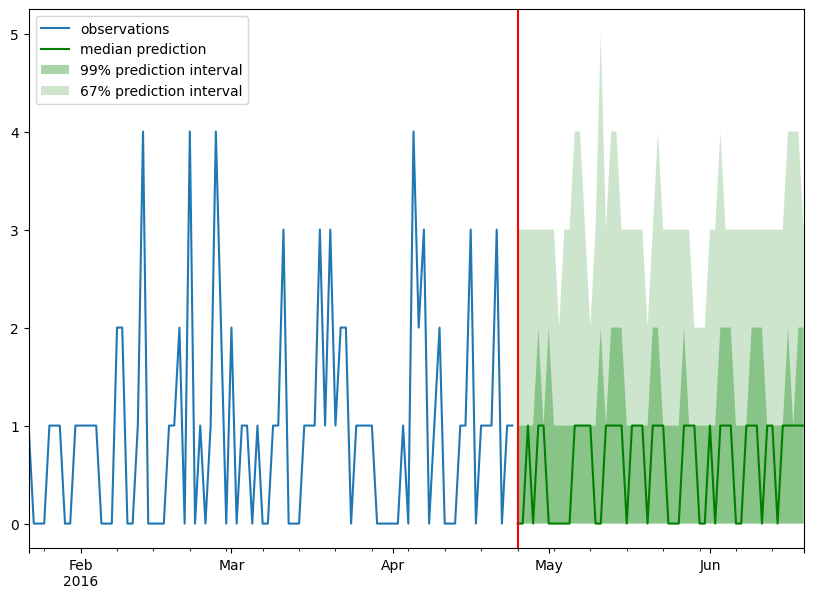

<Figure size 640x480 with 0 Axes>

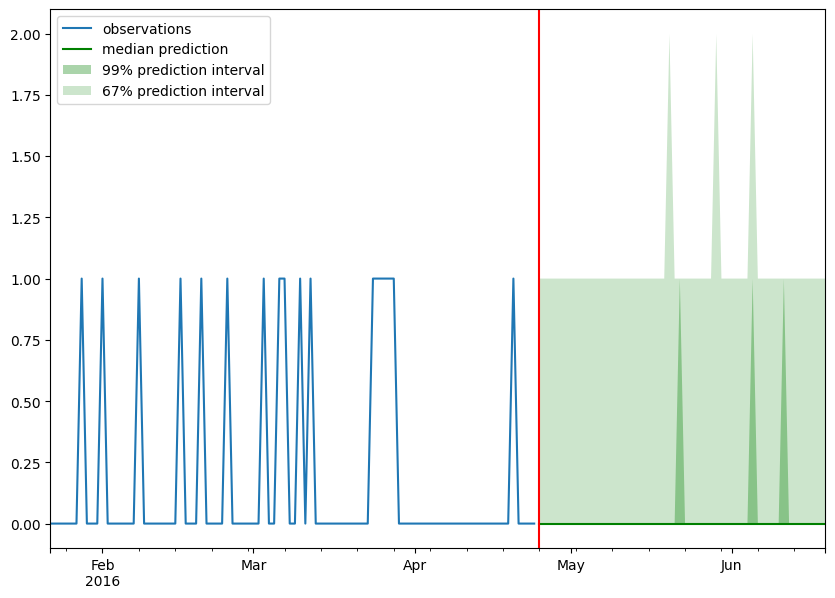

<Figure size 640x480 with 0 Axes>

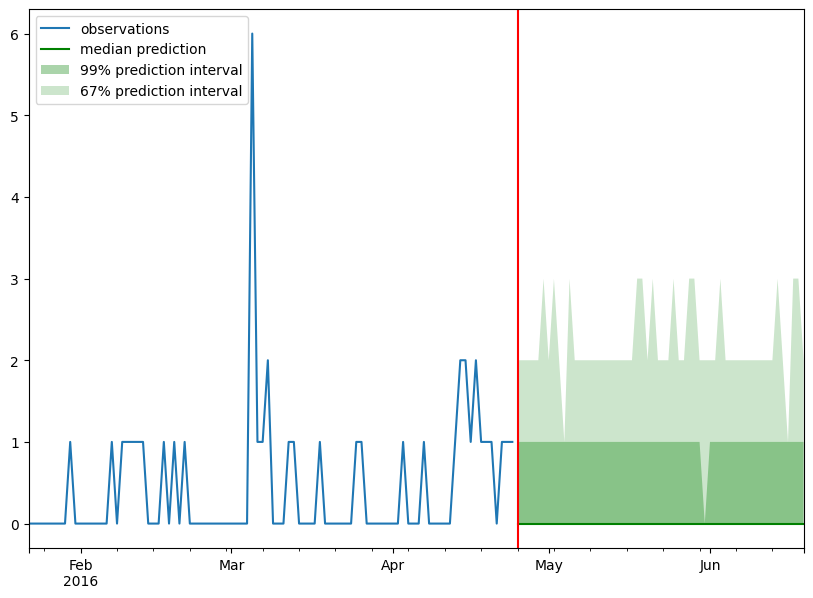

<Figure size 640x480 with 0 Axes>

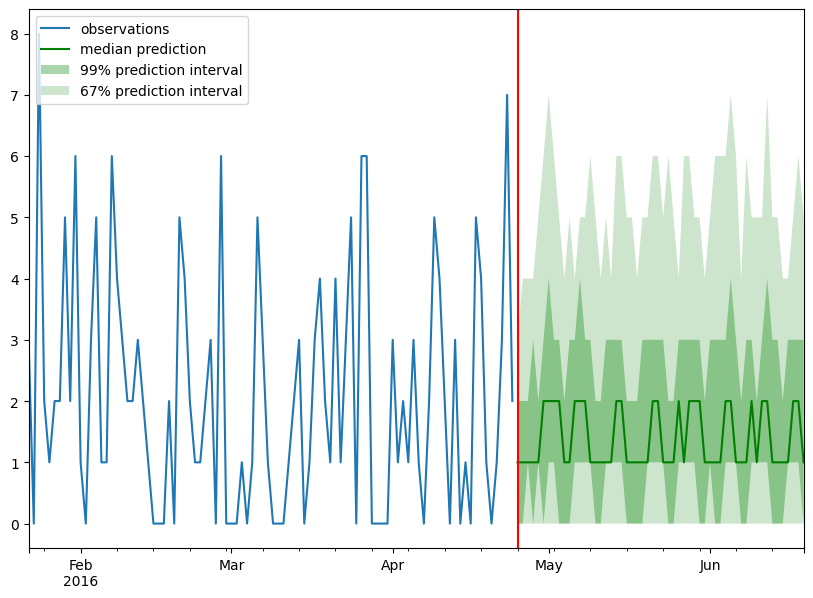

<Figure size 640x480 with 0 Axes>

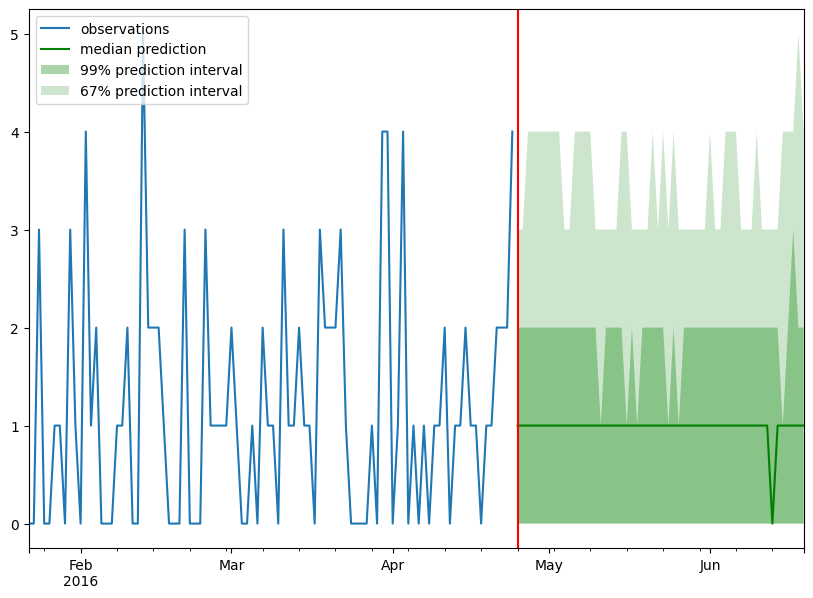

<Figure size 640x480 with 0 Axes>

In [112]:
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-2]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r', label='2')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)